# Individual Customer Churn Prediction


## 1. Setup and Configuration

### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_recall_curve
)

# Imbalanced-learn for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
import xgboost as xgb

# SHAP for interpretability
import shap

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


### 1.2 Define Configuration Parameters

In [2]:
# Model configuration
TEST_SIZE = 0.2
CV_FOLDS = 5
N_ITER_SEARCH = 50  # For RandomizedSearchCV

# Business parameters
AVG_CUSTOMER_VALUE = 5000  # £5,000 per customer
INTERVENTION_COST = 150    # £150 per intervention
INTERVENTION_SUCCESS_RATE = 0.6  # 60% success rate
TARGET_CHURN_REDUCTION = 0.15  # Target: reduce churn from 20.4% to 15%

# Baseline metrics from group project
BASELINE_METRICS = {
    'Model': 'Random Forest (Group Baseline)',
    'Accuracy': 0.8545,
    'Precision': 0.8295,
    'Recall': 0.3587,
    'F1-Score': 0.5009,
    'ROC_AUC': 0.8446
}

print("Configuration Parameters:")
print("  Test Size: {}%".format(int(TEST_SIZE * 100)))
print("  CV Folds: {}".format(CV_FOLDS))
print("  Random Seed: {}".format(RANDOM_SEED))

print("Group Baseline Performance:")
for key, value in BASELINE_METRICS.items():
    if isinstance(value, float):
        print("  {}: {:.4f}".format(key, value))
    else:
        print("  {}: {}".format(key, value))


Configuration Parameters:
  Test Size: 20%
  CV Folds: 5
  Random Seed: 42
Group Baseline Performance:
  Model: Random Forest (Group Baseline)
  Accuracy: 0.8545
  Precision: 0.8295
  Recall: 0.3587
  F1-Score: 0.5009
  ROC_AUC: 0.8446


## 2. Data Loading and Initial Audit

### 2.1 Load Data

In [3]:
# Load dataset
df = pd.read_csv('Churn_Modelling_Cleaned.csv')

print("Dataset Overview:")
print("  Shape: {} rows × {} columns".format(df.shape[0], df.shape[1]))
print("  Memory usage: {:.2f} MB".format(df.memory_usage(deep=True).sum() / 1024**2))

print("Data Types:")
print(df.dtypes)

print("Missing Values:")
print(df.isnull().sum())

print("Duplicate Rows:", df.duplicated().sum())

print("Target Distribution:")
print(df['Exited'].value_counts())

print("Churn Rate: {:.2f}%".format(df['Exited'].mean() * 100))

Dataset Overview:
  Shape: 10000 rows × 11 columns
  Memory usage: 1.88 MB
Data Types:
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
Missing Values:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Duplicate Rows: 0
Target Distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64
Churn Rate: 20.37%


### 2.2 Document Dataset Characteristics

In [4]:
# Create data dictionary summary
data_summary = pd.DataFrame({
    'Feature': df.columns,
    'Type': df.dtypes,
    'Unique_Values': [df[col].nunique() for col in df.columns],
    'Missing_%': [df[col].isnull().sum() / len(df) * 100 for col in df.columns],
    'Sample_Values': [str(df[col].head(3).tolist()) for col in df.columns]
})

print("Data Dictionary Summary:")
print(data_summary.to_string(index=False))

# Statistical summary
print("Statistical Summary of Numerical Features:")
print(df.describe().round(2))

Data Dictionary Summary:
        Feature    Type  Unique_Values  Missing_%                     Sample_Values
    CreditScore   int64            460        0.0                   [619, 608, 502]
      Geography  object              3        0.0     ['France', 'Spain', 'France']
         Gender  object              2        0.0    ['Female', 'Female', 'Female']
            Age   int64             70        0.0                      [42, 41, 42]
         Tenure   int64             11        0.0                         [2, 1, 8]
        Balance float64           6382        0.0         [0.0, 83807.86, 159660.8]
  NumOfProducts   int64              4        0.0                         [1, 1, 3]
      HasCrCard   int64              2        0.0                         [1, 0, 1]
 IsActiveMember   int64              2        0.0                         [1, 1, 0]
EstimatedSalary float64           9999        0.0 [101348.88, 112542.58, 113931.57]
         Exited   int64              2        0.0  

## 3. Advanced Feature Engineering

### 3.1 Recreate Group Features

In [5]:
# Recreate features from group project
df['BalanceIsZero'] = (df['Balance'] == 0).astype(int)
df['Age_Balance_Interaction'] = df['Age'] * df['Balance']
df['AgeBin'] = pd.cut(df['Age'], bins=[18,25,35,45,60,100],
                      labels=['18-25','26-35','36-45','46-60','60+'], include_lowest=True)


### 3.2 Create New Advanced Features

**Rationale:** Based on domain knowledge and EDA insights, I engineer additional features to capture complex patterns.

In [6]:
# 1. Tenure-based features
df['IsNewCustomer'] = (df['Tenure'] <= 2).astype(int)
df['IsLongTermCustomer'] = (df['Tenure'] >= 8).astype(int)
df['TenureAgeRatio'] = df['Tenure'] / (df['Age'] + 1)  # +1 to avoid division by zero

# 2. Product engagement features
df['HasSingleProduct'] = (df['NumOfProducts'] == 1).astype(int)
df['HasMultipleProducts'] = (df['NumOfProducts'] >= 3).astype(int)
df['ProductPerTenure'] = df['NumOfProducts'] / (df['Tenure'] + 1)

# 3. Financial health indicators
df['BalanceToSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1)
df['IsHighBalance'] = (df['Balance'] > df['Balance'].quantile(0.75)).astype(int)
df['IsLowBalance'] = (df['Balance'] < df['Balance'].quantile(0.25)).astype(int)

# 4. Credit-related features
df['CreditScoreCategory'] = pd.cut(df['CreditScore'], 
                                     bins=[0, 580, 670, 740, 900],
                                     labels=['Poor', 'Fair', 'Good', 'Excellent'])
df['IsExcellentCredit'] = (df['CreditScore'] >= 740).astype(int)
df['IsPoorCredit'] = (df['CreditScore'] < 580).astype(int)

# 5. Activity and engagement compound features
df['InactiveWithCard'] = ((df['IsActiveMember'] == 0) & (df['HasCrCard'] == 1)).astype(int)
df['ActiveWithoutCard'] = ((df['IsActiveMember'] == 1) & (df['HasCrCard'] == 0)).astype(int)

# 6. Geographic risk features (based on group findings: Germany has 32.4% churn)
df['IsHighRiskGeography'] = (df['Geography'] == 'Germany').astype(int)

# 7. Demographic risk features (based on findings: Female customers churn at 25.1%)
df['IsHighRiskDemographic'] = ((df['Gender'] == 'Female') & 
                                (df['Geography'] == 'Germany')).astype(int)

# 8. Age-related risk features (46-60 age group has 51.1% churn)
df['IsHighRiskAge'] = ((df['Age'] >= 46) & (df['Age'] <= 60)).astype(int)
df['AgeTenureInteraction'] = df['Age'] * df['Tenure']

# 9. Composite risk score (manual feature combining multiple risk factors)
df['RiskScore'] = (
    df['IsHighRiskGeography'] * 2 +
    df['IsHighRiskAge'] * 2 +
    df['HasSingleProduct'] * 1.5 +
    (1 - df['IsActiveMember']) * 1.5 +
    df['BalanceIsZero'] * 1
)


### 3.3 Feature Importance Analysis - New Features

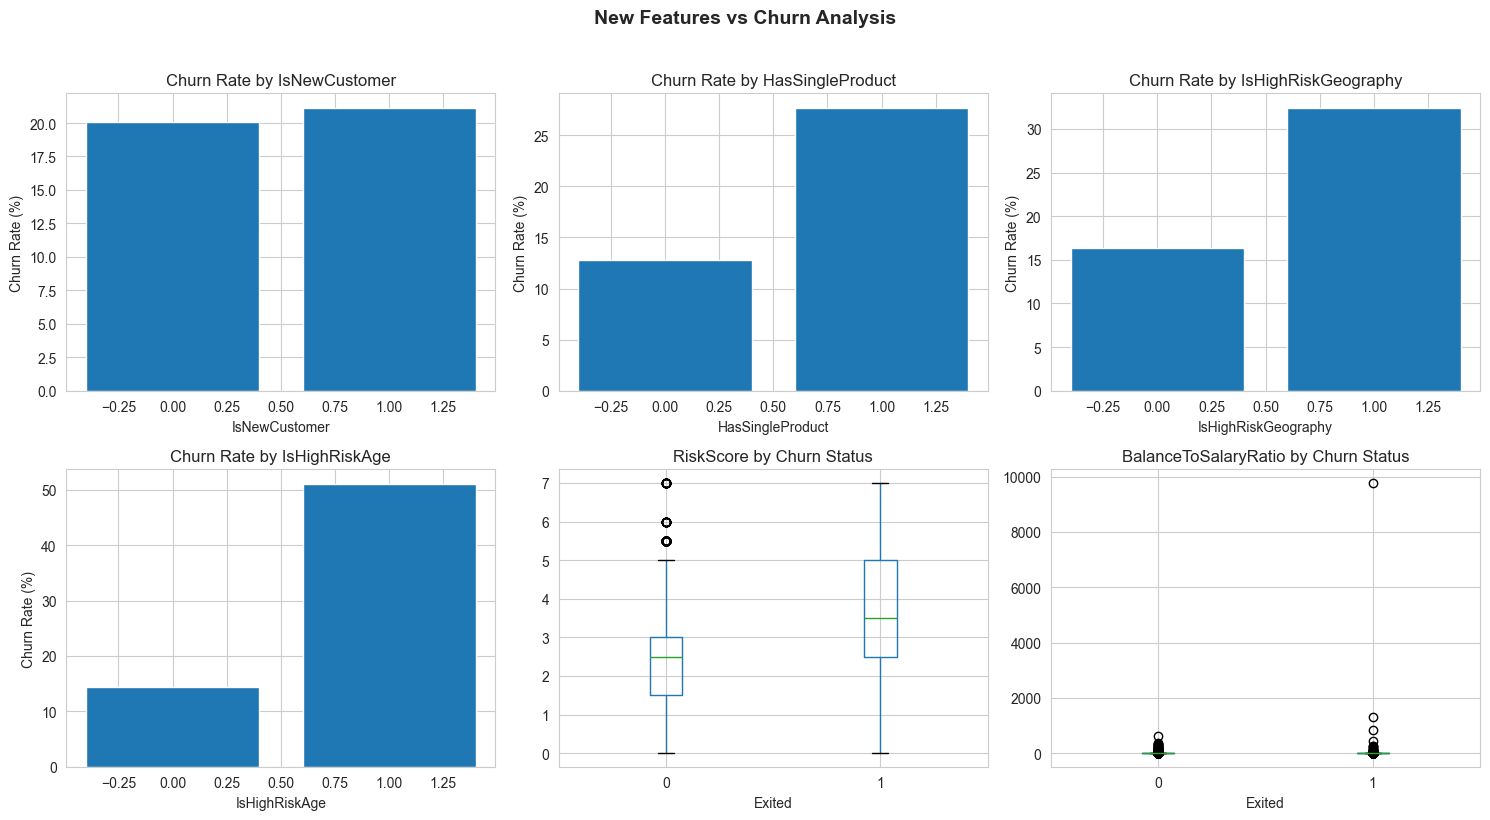

RiskScore               0.400608
IsHighRiskAge           0.339065
HasSingleProduct        0.185447
IsHighRiskGeography     0.173488
BalanceToSalaryRatio    0.025963
IsNewCustomer           0.011225
Name: Exited, dtype: float64


In [7]:
# Quick analysis of new features vs churn
new_features = ['IsNewCustomer', 'HasSingleProduct', 'IsHighRiskGeography', 
                'IsHighRiskAge', 'RiskScore', 'BalanceToSalaryRatio']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, feature in enumerate(new_features):
    if df[feature].dtype in ['int64', 'float64']:
        if df[feature].nunique() <= 3:
            churn_by_feature = df.groupby(feature)['Exited'].mean()
            axes[idx].bar(churn_by_feature.index, churn_by_feature.values * 100)
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Churn Rate (%)')
            axes[idx].set_title(f'Churn Rate by {feature}')
        else:
            df.boxplot(column=feature, by='Exited', ax=axes[idx])
            axes[idx].set_title(f'{feature} by Churn Status')
            
plt.suptitle('New Features vs Churn Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Calculate correlation with target
correlations = df[new_features + ['Exited']].corr()['Exited'].drop('Exited').sort_values(ascending=False)
print(correlations)

## 4. Data Preparation for Modeling

### 4.1 Prepare Features and Target

In [8]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender', 'AgeBin', 'CreditScoreCategory'], 
                              drop_first=False)

# Separate features and target
X = df_encoded.drop(['Exited'], axis=1)
y = df_encoded['Exited']

print("Feature matrix shape: {}".format(X.shape))
print("Target vector shape: {}".format(y.shape))
print("Total features: {}".format(X.shape[1]))
print("Feature list:")
print(X.columns.tolist())


Feature matrix shape: (10000, 42)
Target vector shape: (10000,)
Total features: 42
Feature list:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'BalanceIsZero', 'Age_Balance_Interaction', 'IsNewCustomer', 'IsLongTermCustomer', 'TenureAgeRatio', 'HasSingleProduct', 'HasMultipleProducts', 'ProductPerTenure', 'BalanceToSalaryRatio', 'IsHighBalance', 'IsLowBalance', 'IsExcellentCredit', 'IsPoorCredit', 'InactiveWithCard', 'ActiveWithoutCard', 'IsHighRiskGeography', 'IsHighRiskDemographic', 'IsHighRiskAge', 'AgeTenureInteraction', 'RiskScore', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'AgeBin_18-25', 'AgeBin_26-35', 'AgeBin_36-45', 'AgeBin_46-60', 'AgeBin_60+', 'CreditScoreCategory_Poor', 'CreditScoreCategory_Fair', 'CreditScoreCategory_Good', 'CreditScoreCategory_Excellent']


### 4.2 Train-Test Split with Stratification

In [9]:
# Split data - SAME as group project for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_SEED, 
    stratify=y
)

print("Training set: {} samples ({:.1f}%)".format(X_train.shape[0], X_train.shape[0] / len(X) * 100))
print("Test set: {} samples ({:.1f}%)".format(X_test.shape[0], X_test.shape[0] / len(X) * 100))

print("Class distribution in training set:")
print(y_train.value_counts())
print("  Churn rate: {:.2f}%".format(y_train.mean() * 100))

print("Class distribution in test set:")
print(y_test.value_counts())
print("  Churn rate: {:.2f}%".format(y_test.mean() * 100))


Training set: 8000 samples (80.0%)
Test set: 2000 samples (20.0%)
Class distribution in training set:
Exited
0    6370
1    1630
Name: count, dtype: int64
  Churn rate: 20.38%
Class distribution in test set:
Exited
0    1593
1     407
Name: count, dtype: int64
  Churn rate: 20.35%


## 5. Model Development and Improvement

### 5.1 Baseline Model Reproduction (Group Model)

In [10]:
# Reproduce group baseline model with SAME hyperparameters
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=RANDOM_SEED,
    class_weight=None
)

# Train and evaluate
baseline_rf.fit(X_train, y_train)
y_pred_baseline = baseline_rf.predict(X_test)
y_pred_proba_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
baseline_results = {
    'Model': 'Baseline RF (Reproduced)',
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1-Score': f1_score(y_test, y_pred_baseline),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_baseline)
}

print("Baseline Model Performance (Reproduced with new features):")
for key, value in baseline_results.items():
    if isinstance(value, float):
        print("  {}: {:.4f}".format(key, value))
    else:
        print("  {}: {}".format(key, value))

print("Comparison with Group Baseline:")
for key in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC']:
    group_val = BASELINE_METRICS[key]
    new_val = baseline_results[key]
    diff = new_val - group_val
    print("{:12s}: Group={:.4f} | New={:.4f} | Diff={:+.4f}".format(key, group_val, new_val, diff))


Baseline Model Performance (Reproduced with new features):
  Model: Baseline RF (Reproduced)
  Accuracy: 0.8575
  Precision: 0.7961
  Recall: 0.4029
  F1-Score: 0.5351
  ROC_AUC: 0.8580
Comparison with Group Baseline:
Accuracy    : Group=0.8545 | New=0.8575 | Diff=+0.0030
Precision   : Group=0.8295 | New=0.7961 | Diff=-0.0334
Recall      : Group=0.3587 | New=0.4029 | Diff=+0.0442
F1-Score    : Group=0.5009 | New=0.5351 | Diff=+0.0342
ROC_AUC     : Group=0.8446 | New=0.8580 | Diff=+0.0134


### 5.2 Improved Model 1: Random Forest with Hyperparameter Tuning

In [11]:
# Define hyperparameter search space
rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}


print("Search space size: {} parameters".format(len(rf_param_dist)))
print("Number of iterations: {}".format(N_ITER_SEARCH))
print("CV folds: {}".format(CV_FOLDS))


# Setup cross-validation
cv_strategy = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Randomized search
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_SEED),
    param_distributions=rf_param_dist,
    n_iter=N_ITER_SEARCH,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)

rf_random_search.fit(X_train, y_train)


print("Best Random Forest Configuration:")
print("Best CV Score (ROC AUC): {:.4f}".format(rf_random_search.best_score_))
print("Best Parameters:")
for param, value in rf_random_search.best_params_.items():
    print("  {}: {}".format(param, value))


# Get best model
best_rf = rf_random_search.best_estimator_

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_results = {
    'Model': 'Optimized Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_rf)
}

print("Optimized Random Forest Test Performance:")
for key, value in rf_results.items():
    if isinstance(value, float):
        print("  {}: {:.4f}".format(key, value))
    else:
        print("  {}: {}".format(key, value))


Search space size: 6 parameters
Number of iterations: 50
CV folds: 5
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Configuration:
Best CV Score (ROC AUC): 0.8593
Best Parameters:
  n_estimators: 500
  min_samples_split: 15
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 10
  class_weight: None
Optimized Random Forest Test Performance:
  Model: Optimized Random Forest
  Accuracy: 0.8695
  Precision: 0.8259
  Recall: 0.4545
  F1-Score: 0.5864
  ROC_AUC: 0.8647


### 5.3 Improved Model 2: XGBoost with Hyperparameter Tuning

In [12]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define XGBoost hyperparameter search space
xgb_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, scale_pos_weight]
}

print("Calculated scale_pos_weight: {:.2f}".format(scale_pos_weight))
print("Search space size: {} parameters".format(len(xgb_param_dist)))
print("Number of iterations: {}".format(N_ITER_SEARCH))



# Randomized search
xgb_random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_SEED, eval_metric='logloss'),
    param_distributions=xgb_param_dist,
    n_iter=N_ITER_SEARCH,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)

xgb_random_search.fit(X_train, y_train)

print("Best XGBoost Configuration:")
print("Best CV Score (ROC AUC): {:.4f}".format(xgb_random_search.best_score_))

print("Best Parameters:")
for param, value in xgb_random_search.best_params_.items():
    print("  {}: {}".format(param, value))


# Get best model
best_xgb = xgb_random_search.best_estimator_

# Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

xgb_results = {
    'Model': 'Optimized XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_xgb)
}

print("Optimized XGBoost Test Performance:")
for key, value in xgb_results.items():
    if isinstance(value, float):
        print("  {}: {:.4f}".format(key, value))
    else:
        print("  {}: {}".format(key, value))


Calculated scale_pos_weight: 3.91
Search space size: 8 parameters
Number of iterations: 50
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Configuration:
Best CV Score (ROC AUC): nan
Best Parameters:
  subsample: 0.8
  scale_pos_weight: 3.9079754601226995
  n_estimators: 500
  min_child_weight: 5
  max_depth: 3
  learning_rate: 0.05
  gamma: 0
  colsample_bytree: 1.0
Optimized XGBoost Test Performance:
  Model: Optimized XGBoost
  Accuracy: 0.8065
  Precision: 0.5170
  Recall: 0.7469
  F1-Score: 0.6111
  ROC_AUC: 0.8609


### 5.4 Improved Model 3: Random Forest with SMOTE

In [13]:
# Create pipeline with SMOTE and best RF parameters
smote_rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('classifier', RandomForestClassifier(**rf_random_search.best_params_, random_state=RANDOM_SEED))
])

# Train
smote_rf_pipeline.fit(X_train, y_train)

# Evaluate
y_pred_smote = smote_rf_pipeline.predict(X_test)
y_pred_proba_smote = smote_rf_pipeline.predict_proba(X_test)[:, 1]

smote_results = {
    'Model': 'RF with SMOTE',
    'Accuracy': accuracy_score(y_test, y_pred_smote),
    'Precision': precision_score(y_test, y_pred_smote),
    'Recall': recall_score(y_test, y_pred_smote),
    'F1-Score': f1_score(y_test, y_pred_smote),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_smote)
}

print("RF with SMOTE Test Performance:")
for key, value in smote_results.items():
    if isinstance(value, float):
        print("  {}: {:.4f}".format(key, value))
    else:
        print("  {}: {}".format(key, value))


RF with SMOTE Test Performance:
  Model: RF with SMOTE
  Accuracy: 0.8570
  Precision: 0.6850
  Recall: 0.5504
  F1-Score: 0.6104
  ROC_AUC: 0.8634


### 5.5 Model Comparison Summary

In [14]:
# Compile all results
all_results = pd.DataFrame([
    BASELINE_METRICS,
    baseline_results,
    rf_results,
    xgb_results,
    smote_results
])

print(all_results.to_string(index=False))

# Find best model
best_model_idx = all_results['ROC_AUC'].idxmax()
best_model_name = all_results.loc[best_model_idx, 'Model']
best_model_auc = all_results.loc[best_model_idx, 'ROC_AUC']

print("Best Model: {}".format(best_model_name))
print("ROC AUC: {:.4f}".format(best_model_auc))
print("Improvement over group baseline: {:.2f}%".format(
    (best_model_auc - BASELINE_METRICS['ROC_AUC']) * 100
))

# Select best model for further analysis
if 'XGBoost' in best_model_name:
    final_model = best_xgb
    y_pred_final = y_pred_xgb
    y_pred_proba_final = y_pred_proba_xgb
elif 'SMOTE' in best_model_name:
    final_model = smote_rf_pipeline
    y_pred_final = y_pred_smote
    y_pred_proba_final = y_pred_proba_smote
else:
    final_model = best_rf
    y_pred_final = y_pred_rf
    y_pred_proba_final = y_pred_proba_rf


                         Model  Accuracy  Precision   Recall  F1-Score  ROC_AUC
Random Forest (Group Baseline)    0.8545   0.829500 0.358700  0.500900 0.844600
      Baseline RF (Reproduced)    0.8575   0.796117 0.402948  0.535073 0.857971
       Optimized Random Forest    0.8695   0.825893 0.454545  0.586371 0.864694
             Optimized XGBoost    0.8065   0.517007 0.746929  0.611055 0.860850
                 RF with SMOTE    0.8570   0.685015 0.550369  0.610354 0.863361
Best Model: Optimized Random Forest
ROC AUC: 0.8647
Improvement over group baseline: 2.01%


### 5.6 Comprehensive Performance Visualization

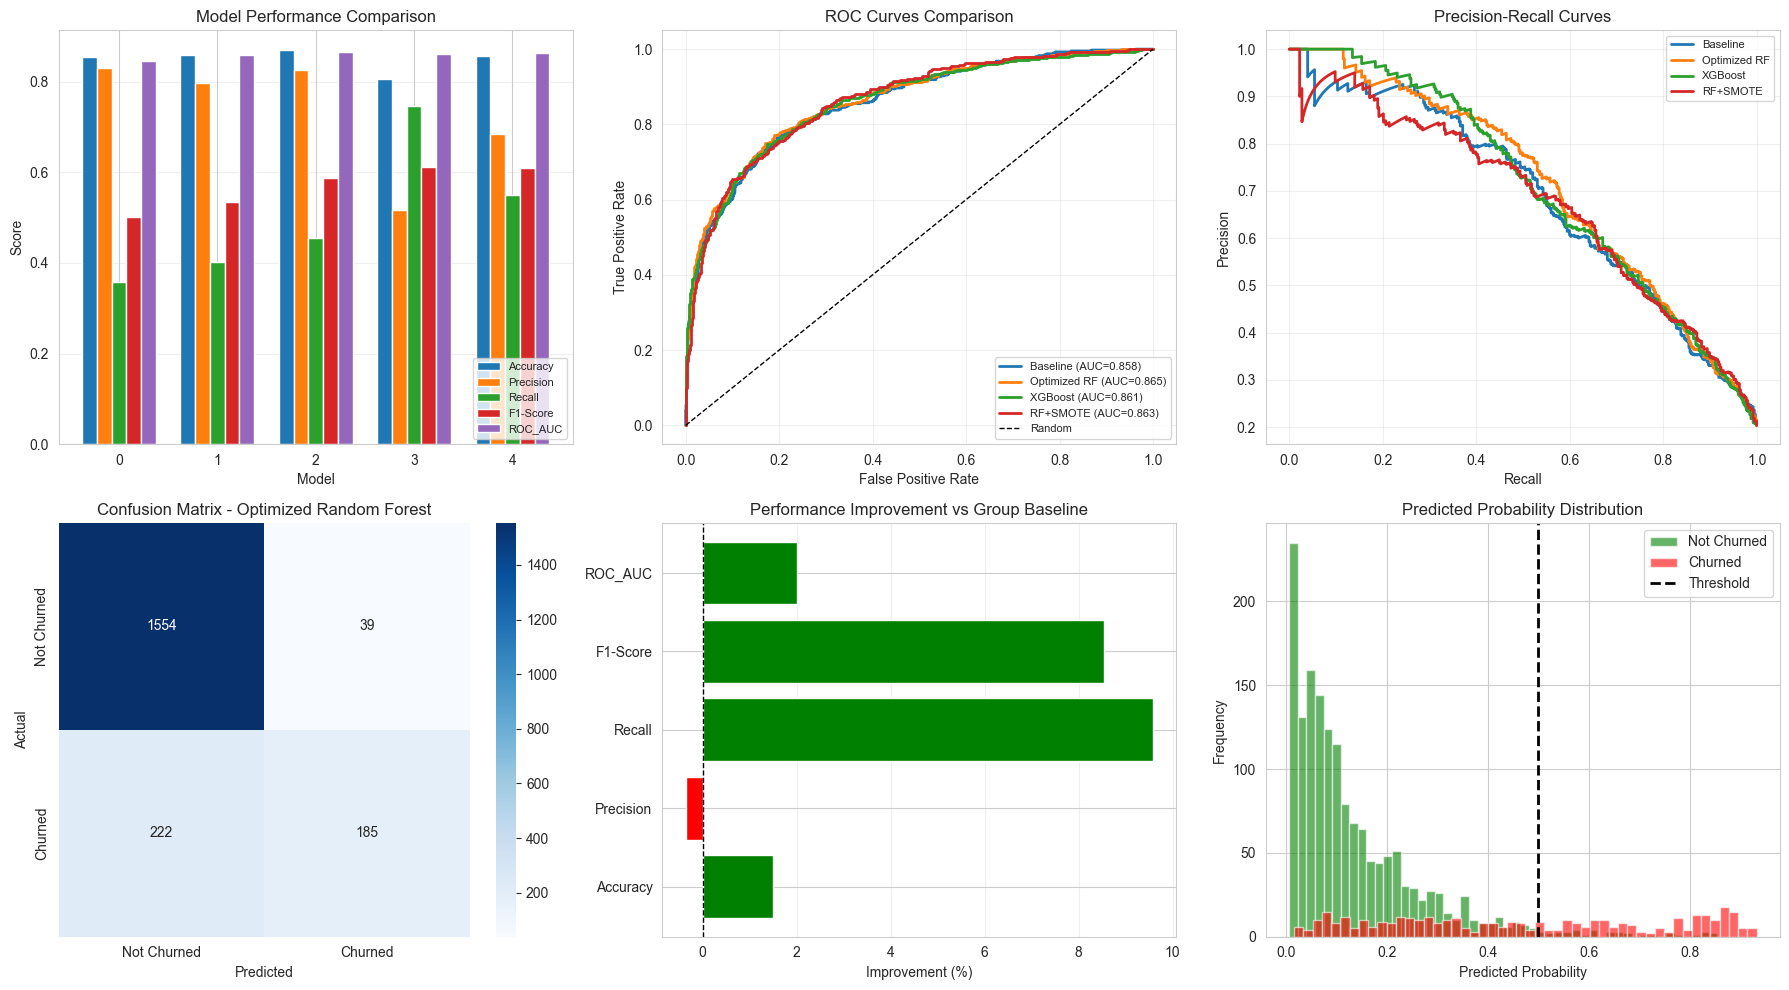

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Metrics comparison bar chart
ax1 = axes[0, 0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC']
x_pos = np.arange(len(all_results))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    ax1.bar(x_pos + i*width, all_results[metric], width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x_pos + width * 2)
ax1.set_xticklabels(range(len(all_results)), rotation=0)
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(axis='y', alpha=0.3)

# 2. ROC Curves
ax2 = axes[0, 1]
models_roc = [
    ('Baseline', y_pred_proba_baseline),
    ('Optimized RF', y_pred_proba_rf),
    ('XGBoost', y_pred_proba_xgb),
    ('RF+SMOTE', y_pred_proba_smote)
]

for name, y_proba in models_roc:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax2.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison')
ax2.legend(loc='lower right', fontsize=8)
ax2.grid(alpha=0.3)

# 3. Precision-Recall Curves
ax3 = axes[0, 2]
for name, y_proba in models_roc:
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ax3.plot(recall, precision, label=name, linewidth=2)

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves')
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(alpha=0.3)

# 4. Confusion Matrix for best model
ax4 = axes[1, 0]
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
ax4.set_title(f'Confusion Matrix - {best_model_name}')
ax4.set_ylabel('Actual')
ax4.set_xlabel('Predicted')

# 5. Metric improvements from baseline
ax5 = axes[1, 1]
improvements = {}
for metric in metrics_to_plot:
    improvements[metric] = (
        (all_results.loc[best_model_idx, metric] - BASELINE_METRICS[metric]) * 100
    )

colors = ['green' if v > 0 else 'red' for v in improvements.values()]
ax5.barh(list(improvements.keys()), list(improvements.values()), color=colors)
ax5.set_xlabel('Improvement (%)')
ax5.set_title('Performance Improvement vs Group Baseline')
ax5.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax5.grid(axis='x', alpha=0.3)

# 6. Probability distribution
ax6 = axes[1, 2]
ax6.hist(y_pred_proba_final[y_test==0], bins=50, alpha=0.6, label='Not Churned', color='green')
ax6.hist(y_pred_proba_final[y_test==1], bins=50, alpha=0.6, label='Churned', color='red')
ax6.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_title('Predicted Probability Distribution')
ax6.legend()

plt.tight_layout()
plt.show()

## 6. Model Interpretability with SHAP

### 6.1 SHAP Analysis for Best Model

In [16]:
# Create SHAP explainer
# Use a sample for faster computation
X_sample = X_test.sample(n=min(500, len(X_test)), random_state=RANDOM_SEED)

if 'XGBoost' in best_model_name:
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_sample)
elif 'SMOTE' in best_model_name:
    clf = final_model.named_steps['classifier']
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
else:
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]


### 6.2 SHAP Summary Plots

<Figure size 1200x800 with 0 Axes>

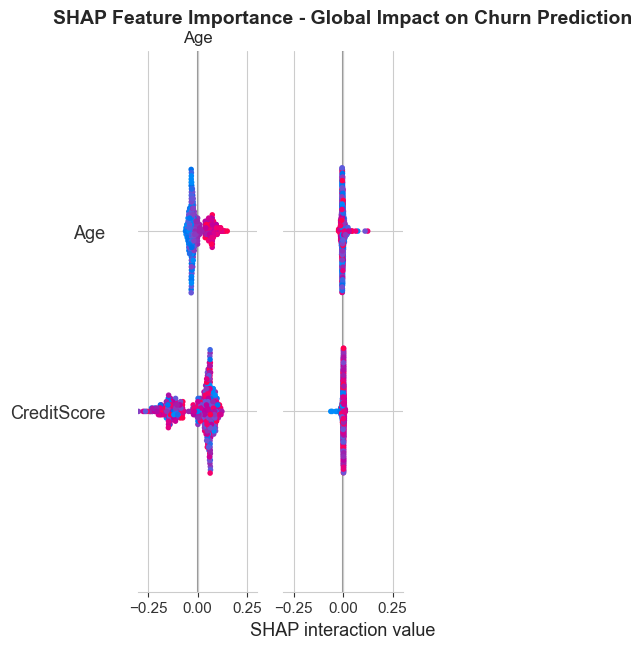

<Figure size 1200x1000 with 0 Axes>

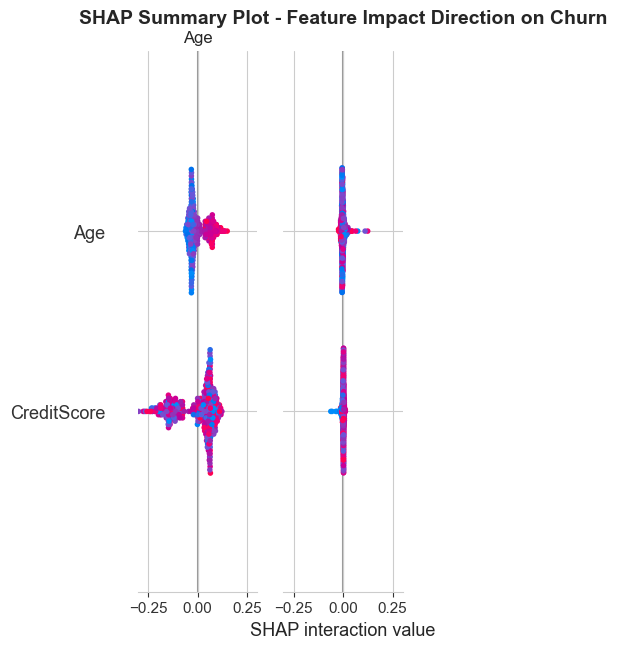

In [17]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Global Impact on Churn Prediction', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact Direction on Churn', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 6.3 Top Features Analysis

In [ ]:
# Calculate mean absolute SHAP values for feature importance
def shap_to_2d(sv, positive_class_index=1, model=None):
    if hasattr(sv, "values"):
        arr = sv.values
    else:
        arr = np.asarray(sv)


    pos_idx = positive_class_index
    if model is not None and hasattr(model, "classes_"):
        try:

            if len(model.classes_) == 2 and 1 in list(model.classes_):
                pos_idx = int(np.where(model.classes_ == 1)[0][0])
        except Exception:
            pass

    if arr.ndim == 3:
        # (n_samples, n_features, n_classes)
        if arr.shape[-1] == 2:
            arr = arr[:, :, pos_idx]
        else:

            arr = arr.mean(axis=-1)
    elif arr.ndim == 1:
        arr = arr.reshape(-1, 1)

    return arr

sv_2d = shap_to_2d(shap_values, positive_class_index=1, model=final_model)

shap_importance = pd.DataFrame({
    'Feature': X_sample.columns,
    'SHAP_Importance': np.abs(sv_2d).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("TOP 15 FEATURES BY SHAP IMPORTANCE")
print(shap_importance.head(15).to_string(index=False))


TOP 15 FEATURES BY SHAP IMPORTANCE
                Feature  SHAP_Importance
                    Age         0.041384
              RiskScore         0.040376
       HasSingleProduct         0.024440
          NumOfProducts         0.022180
           AgeBin_46-60         0.019367
          IsHighRiskAge         0.018070
    HasMultipleProducts         0.015860
         IsActiveMember         0.015148
Age_Balance_Interaction         0.014624
           AgeBin_26-35         0.009360
       InactiveWithCard         0.007505
      Geography_Germany         0.007472
    IsHighRiskGeography         0.007430
                Balance         0.006580
            Gender_Male         0.006440


## 7. Enhanced Fairness Analysis

### 7.1 Fairness Metrics Across Protected Groups

In [19]:
test_indices = X_test.index
df_test_fairness = df.loc[test_indices].copy()
df_test_fairness['Predicted'] = y_pred_final
df_test_fairness['Predicted_Proba'] = y_pred_proba_final
df_test_fairness['Actual'] = y_test.values

def calculate_comprehensive_fairness(df, group_col, group_values):
    results = []
    
    for group in group_values:
        group_data = df[df[group_col] == group]
        
        if len(group_data) == 0:
            continue
        
        # Basic metrics
        accuracy = accuracy_score(group_data['Actual'], group_data['Predicted'])
        precision = precision_score(group_data['Actual'], group_data['Predicted'], zero_division=0)
        recall = recall_score(group_data['Actual'], group_data['Predicted'], zero_division=0)
        f1 = f1_score(group_data['Actual'], group_data['Predicted'], zero_division=0)
        
        # Confusion matrix metrics
        cm = confusion_matrix(group_data['Actual'], group_data['Predicted'])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
        else:
            fpr = fnr = tpr = 0
        
        # Selection rate (percentage predicted positive)
        selection_rate = group_data['Predicted'].mean()
        
        results.append({
            'Group': f"{group_col}_{group}",
            'Sample_Size': len(group_data),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'FPR': fpr,
            'FNR': fnr,
            'Selection_Rate': selection_rate
        })
    
    return pd.DataFrame(results)

# Gender fairness
print("GENDER FAIRNESS ANALYSIS")
gender_fairness = calculate_comprehensive_fairness(df_test_fairness, 'Gender', ['Male', 'Female'])
print(gender_fairness.to_string(index=False))

# Calculate disparities
gender_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'FPR', 'FNR']
print("Gender Disparities:")
for metric in gender_metrics:
    diff = abs(gender_fairness.iloc[0][metric] - gender_fairness.iloc[1][metric])
    print("  {:15s}: {:.4f} ({:.2f}%)".format(metric, diff, diff * 100))


# Geographic fairness
print("GEOGRAPHIC FAIRNESS ANALYSIS")
geo_fairness = calculate_comprehensive_fairness(df_test_fairness, 'Geography', 
                                                 ['France', 'Germany', 'Spain'])
print(geo_fairness.to_string(index=False))

# Calculate max disparities
print("Geographic Disparities (Max - Min):")
for metric in gender_metrics:
    diff = geo_fairness[metric].max() - geo_fairness[metric].min()
    print("  {:15s}: {:.4f} ({:.2f}%)".format(metric, diff, diff * 100))


# Age group fairness
print("AGE GROUP FAIRNESS ANALYSIS")
age_fairness = calculate_comprehensive_fairness(df_test_fairness, 'AgeBin',
                                                 ['18-25', '26-35', '36-45', '46-60', '60+'])
print(age_fairness.to_string(index=False))

GENDER FAIRNESS ANALYSIS
        Group  Sample_Size  Accuracy  Precision   Recall       F1      FPR      FNR  Selection_Rate
  Gender_Male         1070  0.891589   0.802083 0.442529 0.570370 0.021205 0.557471        0.089720
Gender_Female          930  0.844086   0.843750 0.463519 0.598338 0.028694 0.536481        0.137634
Gender Disparities:
  Accuracy       : 0.0475 (4.75%)
  Precision      : 0.0417 (4.17%)
  Recall         : 0.0210 (2.10%)
  F1             : 0.0280 (2.80%)
  FPR            : 0.0075 (0.75%)
  FNR            : 0.0210 (2.10%)
GEOGRAPHIC FAIRNESS ANALYSIS
            Group  Sample_Size  Accuracy  Precision   Recall       F1      FPR      FNR  Selection_Rate
 Geography_France         1021  0.877571   0.837838 0.354286 0.497992 0.014184 0.645714        0.072478
Geography_Germany          504  0.831349   0.789474 0.596026 0.679245 0.067989 0.403974        0.226190
  Geography_Spain          475  0.892632   0.916667 0.407407 0.564103 0.007614 0.592593        0.075789
Geogra

### 7.2 Fairness Visualization

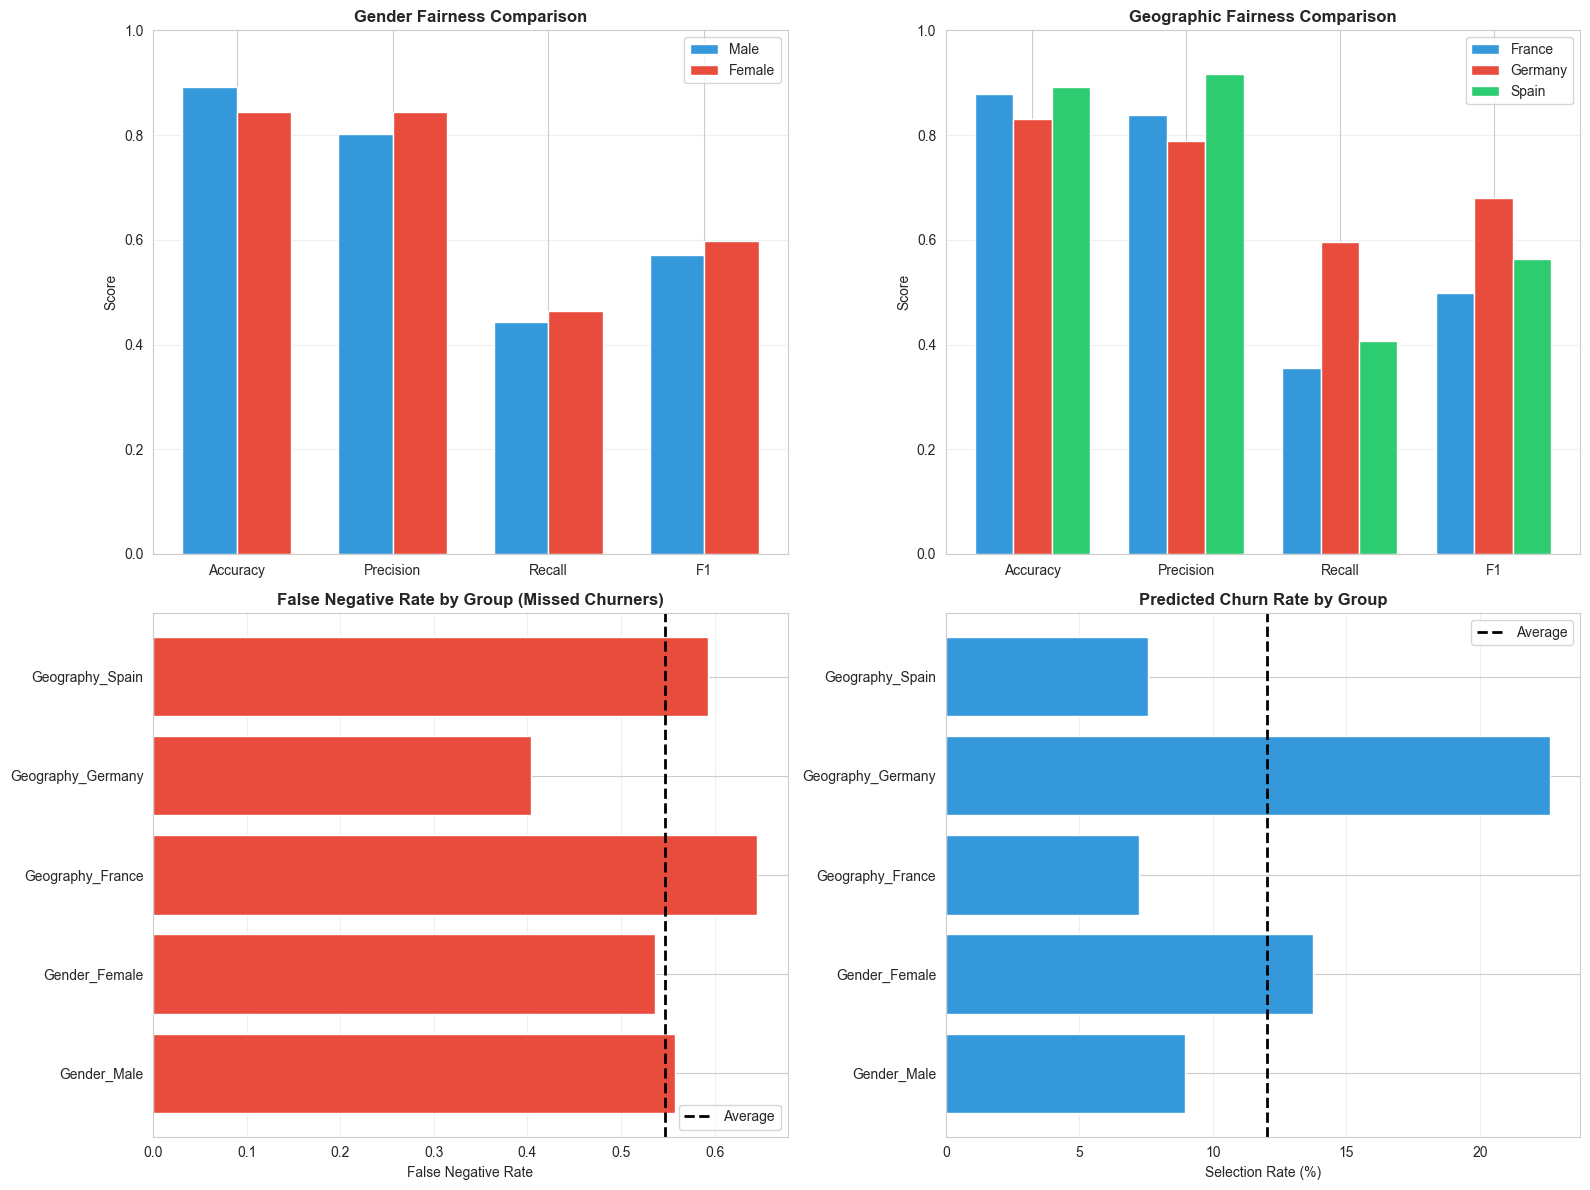

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gender fairness metrics
ax1 = axes[0, 0]
metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_plot))
width = 0.35

male_vals = [gender_fairness[gender_fairness['Group']=='Gender_Male'][m].values[0] for m in metrics_plot]
female_vals = [gender_fairness[gender_fairness['Group']=='Gender_Female'][m].values[0] for m in metrics_plot]

ax1.bar(x - width/2, male_vals, width, label='Male', color='#3498db')
ax1.bar(x + width/2, female_vals, width, label='Female', color='#e74c3c')
ax1.set_ylabel('Score')
ax1.set_title('Gender Fairness Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_plot)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Geographic fairness metrics
ax2 = axes[0, 1]
x = np.arange(len(metrics_plot))
width = 0.25

france_vals = [geo_fairness[geo_fairness['Group']=='Geography_France'][m].values[0] for m in metrics_plot]
germany_vals = [geo_fairness[geo_fairness['Group']=='Geography_Germany'][m].values[0] for m in metrics_plot]
spain_vals = [geo_fairness[geo_fairness['Group']=='Geography_Spain'][m].values[0] for m in metrics_plot]

ax2.bar(x - width, france_vals, width, label='France', color='#3498db')
ax2.bar(x, germany_vals, width, label='Germany', color='#e74c3c')
ax2.bar(x + width, spain_vals, width, label='Spain', color='#2ecc71')
ax2.set_ylabel('Score')
ax2.set_title('Geographic Fairness Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_plot)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

# 3. False Negative Rate comparison (critical for churn)
ax3 = axes[1, 0]
all_groups = pd.concat([gender_fairness, geo_fairness])
ax3.barh(all_groups['Group'], all_groups['FNR'], color='#e74c3c')
ax3.set_xlabel('False Negative Rate')
ax3.set_title('False Negative Rate by Group (Missed Churners)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.axvline(x=all_groups['FNR'].mean(), color='black', linestyle='--', 
            linewidth=2, label='Average')
ax3.legend()

# 4. Selection Rate (% predicted to churn)
ax4 = axes[1, 1]
ax4.barh(all_groups['Group'], all_groups['Selection_Rate']*100, color='#3498db')
ax4.set_xlabel('Selection Rate (%)')
ax4.set_title('Predicted Churn Rate by Group', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.axvline(x=all_groups['Selection_Rate'].mean()*100, color='black', 
            linestyle='--', linewidth=2, label='Average')
ax4.legend()

plt.tight_layout()
plt.show()


## 8. Strategic Business Application: SME Customer Retention


### 8.1 Business Impact Quantification

In [21]:
# Calculate targeting efficiency
df_test_sorted = df_test_fairness.sort_values('Predicted_Proba', ascending=False)

# Different targeting percentiles
targeting_scenarios = [10, 20, 30, 40]
scenario_results = []

for target_pct in targeting_scenarios:
    n_targeted = int(len(df_test_sorted) * (target_pct/100))
    top_customers = df_test_sorted.head(n_targeted)
    
    churners_captured = top_customers['Actual'].sum()
    total_churners = df_test_fairness['Actual'].sum()
    capture_rate = churners_captured / total_churners if total_churners > 0 else 0
    
    # Financial calculations
    prevented_churns = int(churners_captured * INTERVENTION_SUCCESS_RATE)
    revenue_saved = prevented_churns * AVG_CUSTOMER_VALUE
    intervention_costs = n_targeted * INTERVENTION_COST
    net_benefit = revenue_saved - intervention_costs
    roi = net_benefit / intervention_costs if intervention_costs > 0 else 0
    
    # Precision at top k
    precision_at_k = top_customers['Actual'].mean()
    
    # Lift over random
    baseline_random = target_pct / 100 * total_churners
    lift = churners_captured / baseline_random if baseline_random > 0 else 0
    
    scenario_results.append({
        'Target_Percentile': f"Top {target_pct}%",
        'Customers_Targeted': n_targeted,
        'Churners_Captured': churners_captured,
        'Capture_Rate_%': capture_rate * 100,
        'Precision_at_K_%': precision_at_k * 100,
        'Lift': lift,
        'Prevented_Churns': prevented_churns,
        'Revenue_Saved_£': revenue_saved,
        'Costs_£': intervention_costs,
        'Net_Benefit_£': net_benefit,
        'ROI': roi
    })

scenario_df = pd.DataFrame(scenario_results)


print("TARGETING EFFICIENCY ANALYSIS (Test Set)")
print(scenario_df.to_string(index=False))

# Select optimal strategy (top 20%)
optimal_scenario = scenario_df[scenario_df['Target_Percentile'] == 'Top 20%'].iloc[0]


print("RECOMMENDED STRATEGY: TOP 20% TARGETING")
print("Test Set Performance:")
print("  Customers Targeted: {}".format(optimal_scenario['Customers_Targeted']))
print("  Churners Captured: {} ({:.1f}%)".format(
    optimal_scenario['Churners_Captured'], optimal_scenario['Capture_Rate_%']
))
print("  Lift over Random: {:.2f}x".format(optimal_scenario['Lift']))
print("  Precision at Top 20%: {:.1f}%".format(optimal_scenario['Precision_at_K_%']))
print("  ROI: {:.2f}:1".format(optimal_scenario['ROI']))


TARGETING EFFICIENCY ANALYSIS (Test Set)
Target_Percentile  Customers_Targeted  Churners_Captured  Capture_Rate_%  Precision_at_K_%     Lift  Prevented_Churns  Revenue_Saved_£  Costs_£  Net_Benefit_£       ROI
          Top 10%                 200                170       41.769042         85.000000 4.176904               102           510000    30000         480000 16.000000
          Top 20%                 400                255       62.653563         63.750000 3.132678               153           765000    60000         705000 11.750000
          Top 30%                 600                307       75.429975         51.166667 2.514333               184           920000    90000         830000  9.222222
          Top 40%                 800                337       82.800983         42.125000 2.070025               202          1010000   120000         890000  7.416667
RECOMMENDED STRATEGY: TOP 20% TARGETING
Test Set Performance:
  Customers Targeted: 400
  Churners Captured: 255 (

### 8.2 Annual Impact Projection

In [22]:
# Project to full customer base
total_customers = 10000
current_churn_rate = y.mean()
scale_factor = total_customers / len(df_test_fairness)

# Annual projections
annual_customers_targeted = int(optimal_scenario['Customers_Targeted'] * scale_factor)
annual_churners_captured = int(optimal_scenario['Churners_Captured'] * scale_factor)
annual_prevented_churns = int(optimal_scenario['Prevented_Churns'] * scale_factor)
annual_revenue_saved = int(optimal_scenario['Revenue_Saved_£'] * scale_factor)
annual_costs = int(optimal_scenario['Costs_£'] * scale_factor)
annual_net_benefit = annual_revenue_saved - annual_costs
annual_roi = annual_net_benefit / annual_costs if annual_costs > 0 else 0

# New churn rate calculation
current_annual_churners = int(total_customers * current_churn_rate)
new_annual_churners = current_annual_churners - annual_prevented_churns
new_churn_rate = new_annual_churners / total_customers
churn_reduction = current_churn_rate - new_churn_rate

print("PROJECTED ANNUAL IMPACT (Full Customer Base)")

annual_impact = {
    'Metric': [
        'Total Customer Base',
        'Current Annual Churners',
        'Current Churn Rate (%)',
        'Customers Targeted (20%)',
        'Churners in Target Group',
        'Intervention Success Rate (%)',
        'Prevented Churns',
        'New Annual Churners',
        'New Churn Rate (%)',
        'Churn Reduction (pp)',
        '',
        'Annual Revenue Saved (£)',
        'Annual Intervention Costs (£)',
        'Annual Net Benefit (£)',
        'Return on Investment',
        '',
        'Meets Target Churn Rate (<15%)?',
        'Meets Minimum ROI (3:1)?',
        'Within Budget (£500k)?'
    ],
    'Value': [
        "{:,}".format(total_customers),
        "{:,}".format(current_annual_churners),
        "{:.2f}%".format(current_churn_rate * 100),
        "{:,}".format(annual_customers_targeted),
        "{:,}".format(annual_churners_captured),
        "{:.0f}%".format(INTERVENTION_SUCCESS_RATE * 100),
        "{:,}".format(annual_prevented_churns),
        "{:,}".format(new_annual_churners),
        "{:.2f}%".format(new_churn_rate * 100),
        "{:.2f}".format(churn_reduction * 100),
        '',
        "£{:,}".format(annual_revenue_saved),
        "£{:,}".format(annual_costs),
        "£{:,}".format(annual_net_benefit),
        "{:.2f}:1".format(annual_roi),
        '',
        "YES" if new_churn_rate < 0.15 else "NO",
        "YES" if annual_roi >= 3 else "NO",
        "YES" if annual_costs <= 500000 else "NO"
    ]
}

impact_df = pd.DataFrame(annual_impact)
print(impact_df.to_string(index=False))


PROJECTED ANNUAL IMPACT (Full Customer Base)
                         Metric      Value
            Total Customer Base     10,000
        Current Annual Churners      2,037
         Current Churn Rate (%)     20.37%
       Customers Targeted (20%)      2,000
       Churners in Target Group      1,275
  Intervention Success Rate (%)        60%
               Prevented Churns        765
            New Annual Churners      1,272
             New Churn Rate (%)     12.72%
           Churn Reduction (pp)       7.65
                                          
       Annual Revenue Saved (£) £3,825,000
  Annual Intervention Costs (£)   £300,000
         Annual Net Benefit (£) £3,525,000
           Return on Investment    11.75:1
                                          
Meets Target Churn Rate (<15%)?        YES
       Meets Minimum ROI (3:1)?        YES
         Within Budget (£500k)?        YES


### 8.3 Risk Analysis and Sensitivity

In [23]:
# Sensitivity analysis on intervention success rate
success_rates = [0.4, 0.5, 0.6, 0.7, 0.8]
sensitivity_results = []

for success_rate in success_rates:
    prevented = int(annual_churners_captured * success_rate)
    revenue = prevented * AVG_CUSTOMER_VALUE
    net = revenue - annual_costs
    roi_val = net / annual_costs if annual_costs > 0 else 0
    new_churn = (current_annual_churners - prevented) / total_customers
    
    sensitivity_results.append({
        'Success_Rate': f"{success_rate*100:.0f}%",
        'Prevented_Churns': prevented,
        'Net_Benefit_£': f"£{net:,}",
        'ROI': f"{roi_val:.2f}:1",
        'New_Churn_Rate': f"{new_churn*100:.2f}%",
        'Meets_Target': '✓' if new_churn < 0.15 and roi_val >= 3 else '✗'
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

print("SENSITIVITY ANALYSIS: Intervention Success Rate")
print(sensitivity_df.to_string(index=False))



SENSITIVITY ANALYSIS: Intervention Success Rate
Success_Rate  Prevented_Churns Net_Benefit_£     ROI New_Churn_Rate Meets_Target
         40%               510    £2,250,000  7.50:1         15.27%            ✗
         50%               637    £2,885,000  9.62:1         14.00%            ✓
         60%               765    £3,525,000 11.75:1         12.72%            ✓
         70%               892    £4,160,000 13.87:1         11.45%            ✓
         80%              1020    £4,800,000 16.00:1         10.17%            ✓


### 8.4 Business Impact Visualization

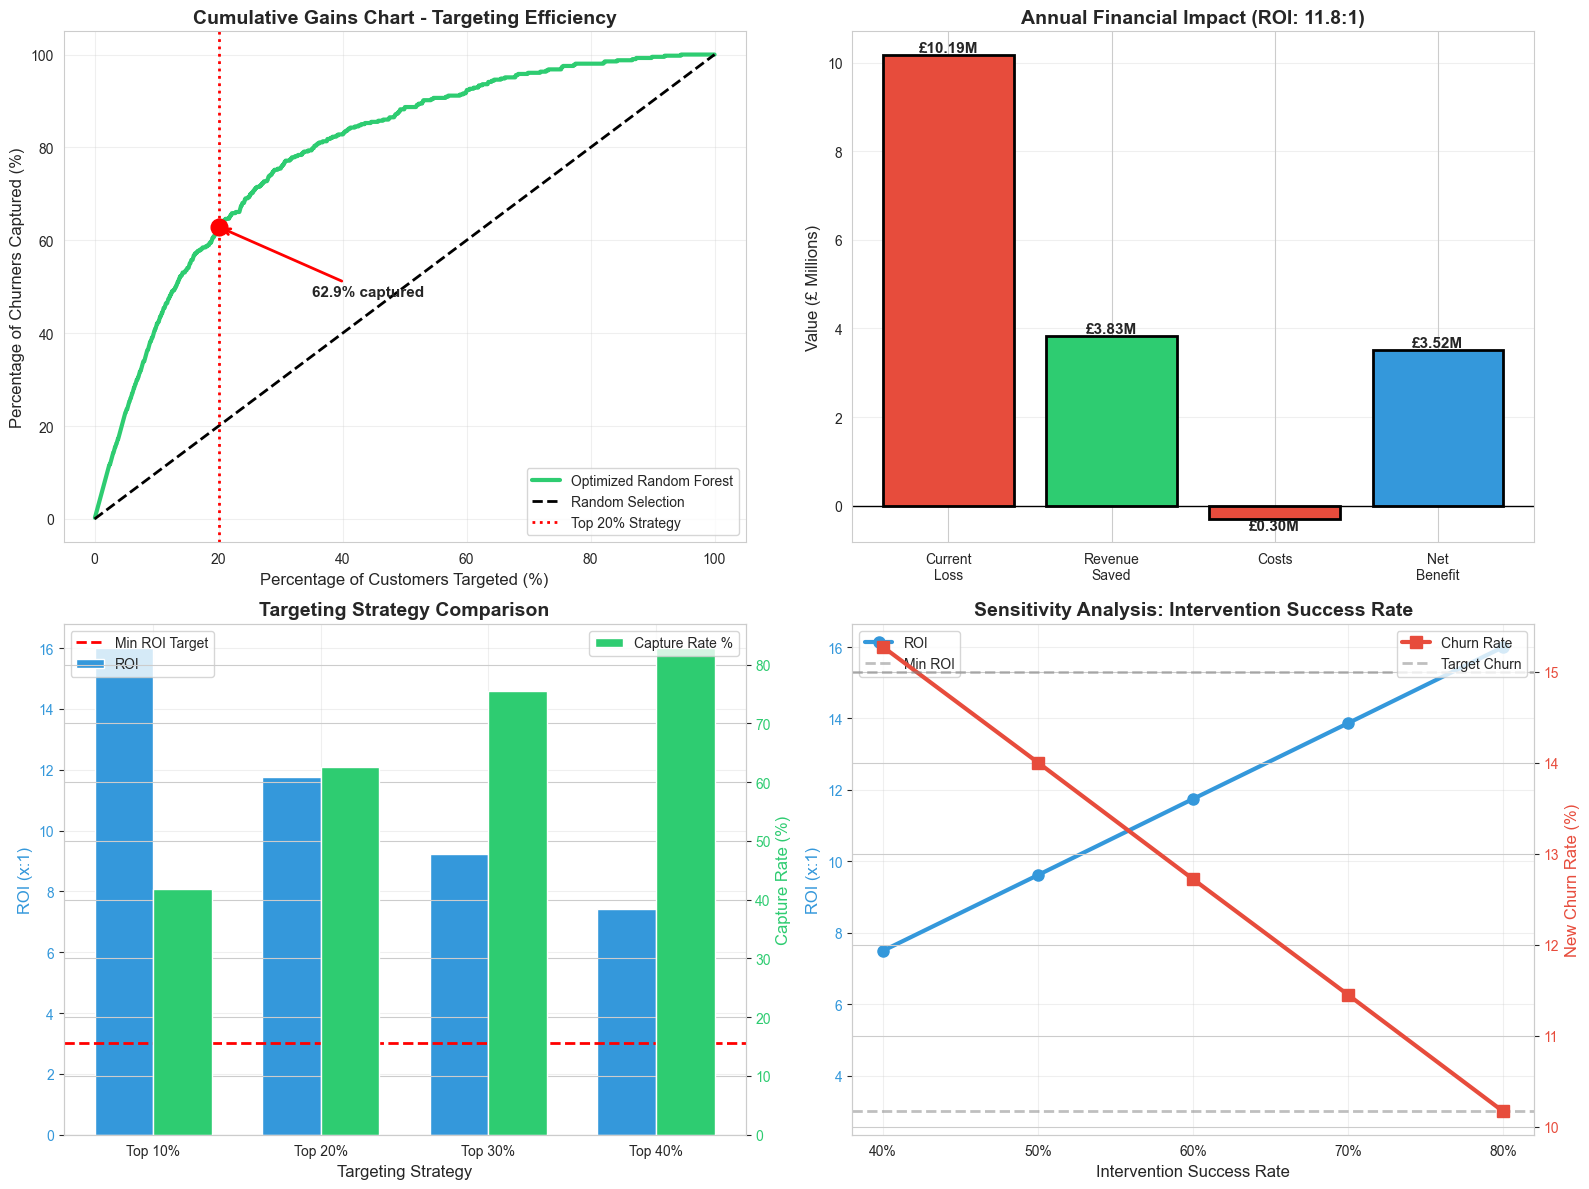

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Gains Chart
ax1 = axes[0, 0]
df_test_sorted_viz = df_test_fairness.sort_values('Predicted_Proba', ascending=False).copy()
df_test_sorted_viz['cumulative_actual'] = df_test_sorted_viz['Actual'].cumsum()
df_test_sorted_viz['cumulative_pct'] = np.arange(1, len(df_test_sorted_viz)+1) / len(df_test_sorted_viz)
df_test_sorted_viz['gains'] = df_test_sorted_viz['cumulative_actual'] / df_test_sorted_viz['Actual'].sum()

ax1.plot(df_test_sorted_viz['cumulative_pct']*100, df_test_sorted_viz['gains']*100, 
         linewidth=3, color='#2ecc71', label=best_model_name)
ax1.plot([0, 100], [0, 100], 'k--', linewidth=2, label='Random Selection')
ax1.axvline(x=20, color='red', linestyle=':', linewidth=2, label='Top 20% Strategy')

# Mark 20% point
idx_20 = int(len(df_test_sorted_viz) * 0.2)
gains_20 = df_test_sorted_viz.iloc[idx_20]['gains'] * 100
ax1.plot(20, gains_20, 'ro', markersize=12)
ax1.annotate(f'{gains_20:.1f}% captured', xy=(20, gains_20), 
             xytext=(35, gains_20-15), fontsize=11, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax1.set_xlabel('Percentage of Customers Targeted (%)', fontsize=12)
ax1.set_ylabel('Percentage of Churners Captured (%)', fontsize=12)
ax1.set_title('Cumulative Gains Chart - Targeting Efficiency', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# 2. Financial Impact Waterfall
ax2 = axes[0, 1]
categories = ['Current\nLoss', 'Revenue\nSaved', 'Costs', 'Net\nBenefit']
values = [
    current_annual_churners * AVG_CUSTOMER_VALUE / 1_000_000,
    annual_revenue_saved / 1_000_000,
    -annual_costs / 1_000_000,
    annual_net_benefit / 1_000_000
]
colors = ['#e74c3c', '#2ecc71', '#e74c3c', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=2)
for bar, val in zip(bars, values):
    height = bar.get_height()
    label = f'£{abs(val):.2f}M'
    va = 'bottom' if val >= 0 else 'top'
    ax2.text(bar.get_x() + bar.get_width()/2., height, label,
             ha='center', va=va, fontweight='bold', fontsize=11)

ax2.set_ylabel('Value (£ Millions)', fontsize=12)
ax2.set_title(f'Annual Financial Impact (ROI: {annual_roi:.1f}:1)', 
              fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

# 3. Targeting Strategy Comparison
ax3 = axes[1, 0]
x_pos = np.arange(len(scenario_df))
width = 0.35

roi_values = scenario_df['ROI'].values
capture_values = scenario_df['Capture_Rate_%'].values

ax3_2 = ax3.twinx()
bars1 = ax3.bar(x_pos - width/2, roi_values, width, label='ROI', color='#3498db')
bars2 = ax3_2.bar(x_pos + width/2, capture_values, width, label='Capture Rate %', color='#2ecc71')

ax3.set_xlabel('Targeting Strategy', fontsize=12)
ax3.set_ylabel('ROI (x:1)', fontsize=12, color='#3498db')
ax3_2.set_ylabel('Capture Rate (%)', fontsize=12, color='#2ecc71')
ax3.set_title('Targeting Strategy Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(scenario_df['Target_Percentile'])
ax3.tick_params(axis='y', labelcolor='#3498db')
ax3_2.tick_params(axis='y', labelcolor='#2ecc71')
ax3.axhline(y=3, color='red', linestyle='--', linewidth=2, label='Min ROI Target')
ax3.legend(loc='upper left')
ax3_2.legend(loc='upper right')
ax3.grid(alpha=0.3)

# 4. Sensitivity Analysis
ax4 = axes[1, 1]
success_rates_plot = [float(r.strip('%'))/100 for r in sensitivity_df['Success_Rate']]
roi_plot = [float(r.split(':')[0]) for r in sensitivity_df['ROI']]
churn_plot = [float(r.strip('%'))/100 for r in sensitivity_df['New_Churn_Rate']]

ax4_2 = ax4.twinx()
line1 = ax4.plot(success_rates_plot, roi_plot, 'o-', linewidth=3, 
                 markersize=8, color='#3498db', label='ROI')
line2 = ax4_2.plot(success_rates_plot, [c*100 for c in churn_plot], 's-', 
                   linewidth=3, markersize=8, color='#e74c3c', label='Churn Rate')

ax4.axhline(y=3, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Min ROI')
ax4_2.axhline(y=15, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Target Churn')

ax4.set_xlabel('Intervention Success Rate', fontsize=12)
ax4.set_ylabel('ROI (x:1)', fontsize=12, color='#3498db')
ax4_2.set_ylabel('New Churn Rate (%)', fontsize=12, color='#e74c3c')
ax4.set_title('Sensitivity Analysis: Intervention Success Rate', fontsize=14, fontweight='bold')
ax4.set_xticks(success_rates_plot)
ax4.set_xticklabels([f"{int(r*100)}%" for r in success_rates_plot])
ax4.tick_params(axis='y', labelcolor='#3498db')
ax4_2.tick_params(axis='y', labelcolor='#e74c3c')
ax4.legend(loc='upper left')
ax4_2.legend(loc='upper right')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()
